In [106]:
#
# Simulating Queues
#

# show graphics inside Jupyter Notebook
%matplotlib inline 

import numpy as np             # np.array()
import matplotlib.pylab as plt # plotting
from scipy import stats        # probability distributions
from itertools import *        # islice

In [299]:
#
# The arrival process is modeled as iterator
#
def IID(Dist):
    while True:
        yield Dist()

def Const(c):
    "Constant series"
    return IID(lambda: c)

def Ber(p):
    "Bernoulli noise"
    return IID(stats.bernoulli(p).rvs)

def Poi(l):
    "Poisson noise"
    return IID(stats.poisson(l).rvs)

def ExampleData():
    # could be extracted from log files, etc.
    return [0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0]

In [300]:
# each call to next represents the arrival at a (1 minute) time window
next(Ber(0.2))

1

In [301]:
# Sampling Helper
def Sample(I, N=1000):
    return np.array(list(islice(I,N)))

In [302]:
Sample(Ber(0.2), 50)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0])

In [303]:
# Visualize Arrival Process
def Plot(I, *args, **kwargs):
    N = kwargs.pop("N", 1000)
    Y = Sample(I,N)
    X = range(len(Y))
    plt.figure(0, figsize=(20,4)) # always use figure 0
    plt.step(X, Y, *args, **kwargs)

def Hist(I, *args, **kwargs):
    N = kwargs.pop("N", 1000)
    # setup plot
    plt.figure(1, figsize=(10,5))
    kwargs['bins'] = int(kwargs.get('bins', np.sqrt(N)))
    H = plt.hist(Sample(I,N), *args, **kwargs)

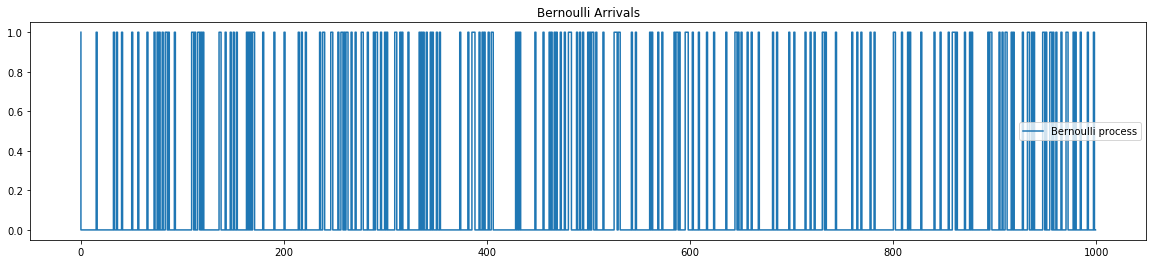

In [304]:
Plot(Ber(0.2))
plt.title("Bernoulli Arrivals")
plt.legend(["Bernoulli process"])

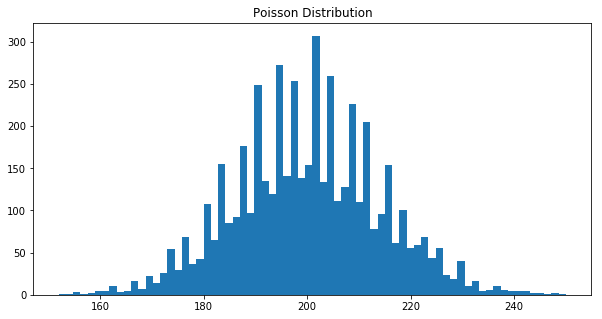

In [305]:
Hist(Poi(200), N=5000)
plt.title("Poisson Distribution")

In [306]:
#
# Computing N(t) and the arrival rate
#
def walk(I):
    s = 0
    for y in I:
        s += y
        yield s

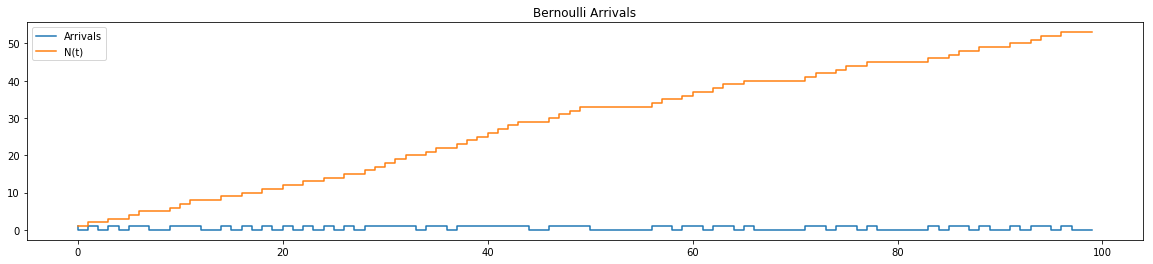

In [307]:
# Simulating Bernoulli arrivals
p = 0.5
N = 100
arrivals    = Sample(Ber(p), N) # arrivals per minute
arrivals_nt = walk(arrivals)    # N(T)
Plot(arrivals)
Plot(arrivals_nt)
plt.title("Bernoulli Arrivals")
plt.legend(["Arrivals", "N(t)"])

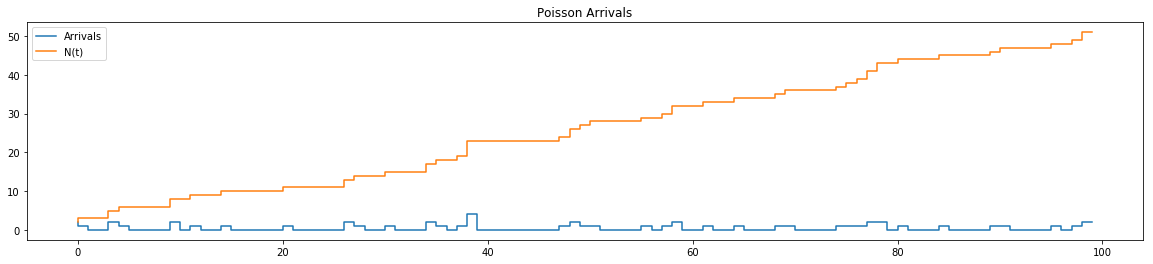

In [308]:
# Simulating Poisson arrivals
p = 0.5
N = 100
arrivals    = Sample(Poi(p), N) # arrivals per minute
arrivals_nt = walk(arrivals)    # N(T)
Plot(arrivals)
Plot(arrivals_nt)
plt.title("Poisson Arrivals")
plt.legend(["Arrivals", "N(t)"])

In [348]:
#
# Arrival rate
#
def time_average(I):
    t = 0.
    s = 0.
    for y in I:
        t += 1
        s += y
        yield float(s)/t

def tail(I, n=-1):
    y_last = None
    t = 0
    for y in I:
        t += 1
        y_last = y
        if t == n:
            break
    return y_last

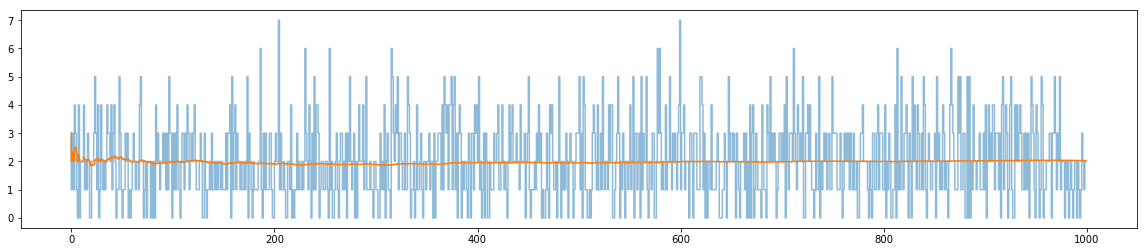

Simulated Arrival Rate:  2.013


In [427]:
p = 2
N = 10000
arrivals    = Sample(Poi(p), N) # arrivals per minute
arrivals_ta = time_average(arrivals) # N(T)
Plot(arrivals, alpha=0.5)
Plot(arrivals_ta)
plt.show()
print("Simulated Arrival Rate: ", last(time_average(arrivals)))
# Hist(arrivals)

In [350]:
#
# Queue implementation
#

# ?/D/1 Queue
# constant service time
def QD1(I, service_time):
    q = 0
    s = -1 # service timer
    for a in I:
        q += a # enqueue arrivals
        s -= 1 # service 'tick'

        # check service timer
        if s == 0:
            yield 1
        else:
            yield 0

        # service next customer
        if s <= 0 and q > 0:
            q -= 1
            s = service_time

# ?/M/1
# Markov (geometric) service times
def QM1(I, S):
    q = 0
    s = -1 # service timer
    for a in I:
        q += a # enqueue arrivals
        s -= 1 # service 'tick'

        # check service timer
        if s == 0:
            yield 1
        else:
            yield 0

        # service next customer
        if s <= 0 and q > 0:
            q -= 1
            s = stats.geom.rvs(1/S)

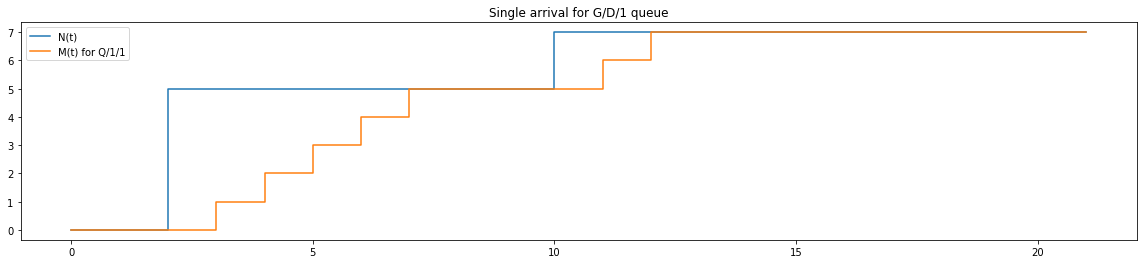

In [351]:
# Constant service duration
A = ExampleData()
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QD1(A, 1)));   legend.append("M(t) for Q/1/1")
#Plot(walk(QD1(A, 2)));   legend.append("M(t) for Q/2/1")
#Plot(walk(QD1(A, 3)));   legend.append("M(t) for Q/3/1")
plt.title("Single arrival for G/D/1 queue")
plt.legend(legend)

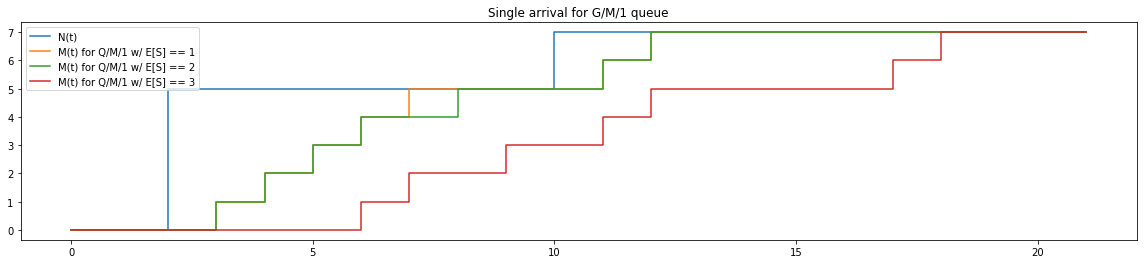

In [365]:
# Random service duration
A = ExampleData()
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QM1(A, 1)));   legend.append("M(t) for Q/M/1 w/ E[S] == 1")
Plot(walk(QM1(A, 2)));   legend.append("M(t) for Q/M/1 w/ E[S] == 2")
Plot(walk(QM1(A, 3)));   legend.append("M(t) for Q/M/1 w/ E[S] == 3")
plt.title("Single arrival for G/M/1 queue")
plt.legend(legend)


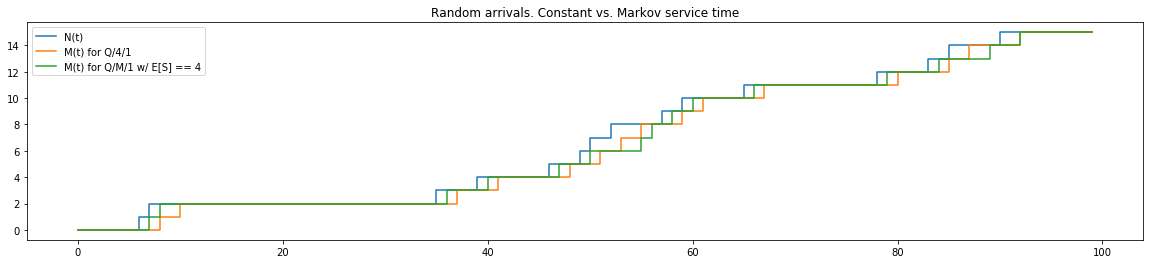

In [366]:
# Random arrivals, Constant vs. Random service durations
A  = Sample(Poi(0.2), 100)
S = 2
legend = []
Plot(walk(A));           legend.append("N(t)")
Plot(walk(QD1(A, S)));   legend.append("M(t) for Q/4/1")
Plot(walk(QM1(A, S)));   legend.append("M(t) for Q/M/1 w/ E[S] == 4")
plt.title("Random arrivals. Constant vs. Markov service time")
plt.legend(legend)

Arrival rate: 0.23
Throughput:   0.095


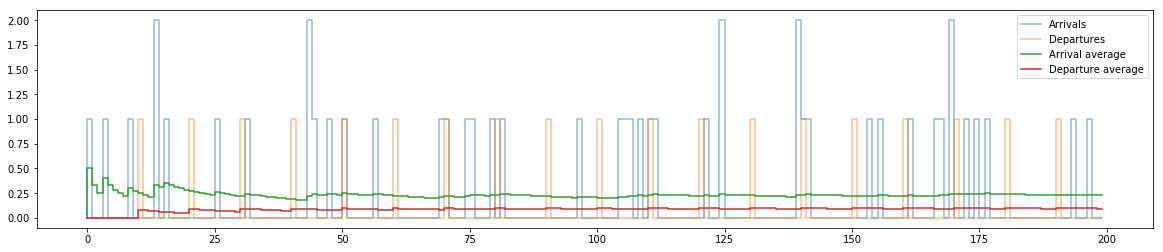

In [423]:
#
# Throughput is the rate of departures
#
A = Sample(Poi(0.2), 200)
S = 10
D = Sample(QD1(A, S))
legend = []
Plot(A, alpha=0.5); legend.append("Arrivals")
Plot(D, alpha=0.5); legend.append("Departures")
Plot(time_average(A)); legend.append("Arrival average")
Plot(time_average(D)); legend.append("Departure average")
plt.legend(legend)
print("Arrival rate:", last(time_average(A)))
print("Throughput:  ", last(time_average(D)))

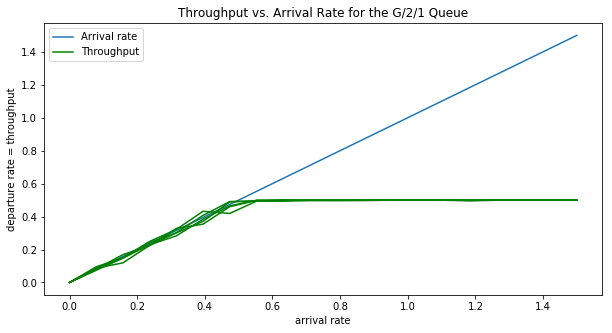

In [484]:
#
# Throughput depending on arrival rate
#

# arrival rate span
L = np.linspace(0, 1.5, 20)
service_time = 2
trials = 5

plt.figure(0, figsize=(10,5))
plt.plot(L,L)
for i in range(trials):
    Y = [ tail(time_average(QD1(Poi(l), service_time)), n=1000) for l in L ]
    plt.plot(L,Y, color="green")

plt.legend(["Arrival rate","Throughput"])
plt.title("Throughput vs. Arrival Rate for the G/2/1 Queue")
plt.xlabel("arrival rate")
plt.ylabel("departure rate = throughput")

In [486]:
#
# Queue Lengths
#
def L(N, M):
    # assumes N, M are already samples
    return N - M

def Ls(N, M):
    return L(N, M) > 0

def Lq(N, M):
    return L(N, M) - Ls(N, M)

Utilization:      rho = Ls =  0.31
Average Queue Length:   Lq =  0.01
Average Service Length: L  =  0.32


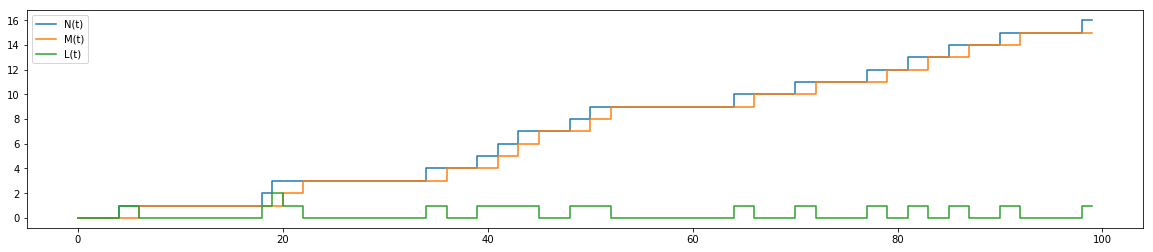

In [487]:
n = 100
l = 0.2
S = 2
A = Sample(Poi(l), n)
D = Sample(QD1(A, S), n)
N = Sample(walk(A), n)
M = Sample(walk(D), n)
legend = []
Plot(N); legend.append("N(t)")
Plot(M); legend.append("M(t)")
Plot(L(N, M)); legend.append("L(t)")
#Plot(Lq(N, M)); legend.append("Lq(t)")
#Plot(-1*Ls(N, M)); legend.append("-Ls(t)")
plt.legend(legend)
print("Utilization:      rho = Ls = ", Ls(N,M).mean()) # same as last(time_average(Ls(N,M)))
print("Average Queue Length:   Lq = ", Lq(N,M).mean())
print("Average Service Length: L  = ", L(N,M).mean())

In [ ]:
#
# Queue lengths vs. arrival rate
#

max_x = 0.6
X = np.linspace(0, max_x, 20)
Q = QM1
service_time = 2
trials = 3
n = 5000

legend = []
plt.figure(figsize=(20,10))
for i in range(trials):
    buf_Ls= []
    buf_L = []
    buf_X = []
    buf_W = []
    for i, arrival_rate in enumerate(X):
        A = Sample(Poi(arrival_rate), n)
        D = Sample(Q(A, service_time), n)
        N = Sample(walk(A), n)
        M = Sample(walk(D), n)
        buf_Ls.append(Ls(N,M).mean())
        buf_L.append(L(N,M).mean())
        buf_W.append(L(N,M).mean() / arrival_rate) # by Little
        buf_X.append(D.mean())
    
    plt.plot(X, X,       color = "grey")
    plt.plot(X, buf_Ls,  color = "blue")
    plt.plot(X, buf_L,   color = "orange")
    plt.plot(X, buf_W,   color = "purple")
    plt.plot(X, buf_X,   color = "green")
    
plt.legend(["Arrival rate", "Ls - Utilization", "L - Concurrency", "W - Residence Duration", "X - Throughput"])
plt.title("Simulating a G/?/1 Queue")
plt.xlabel("Arrival rate")
plt.ylim(0, 5)
plt.xlim(0, max_x)
# -> Compare to theory W

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
